# TP 1 - NLP
| Nome | Matrícula |
|------|-----------|
| João Vítor Santana Depollo | 2021039751 |

### Setup dependencies & Configuration

In [22]:
%pip install gensim
%pip install numpy
%pip install tabulate
%pip install matplotlib
%pip install scipy


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://gi

In [23]:
from tabulate import tabulate
import random
import math
from scipy.spatial.distance import cosine
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus
from matplotlib import pyplot as plt


In [24]:
# É possível escolher o modelo entre SKIPGRAM e CBOW
dataset_path = "questions-words.txt"
model = "SKIPGRAM"
corpus = Text8Corpus("text8")

INFINITY = math.inf
# Ajustar valor de acordo com a quantidade de cores com do processador
WORKERS = 8
# Testar frases aleatórias do dataset
run_random_tests = True

def generate_all_parameters(model_type):
    vectors_sizes = [5,10,15,20,30]
    windows = [ 10,15]
    # ALPHA = 0.001
    epochs_amount = [3,4,5]
    sg = 0 if model_type == "CBOW" else 1
    
    parameters = []
    for vector_size in vectors_sizes:
        for window in windows:
            for epochs in epochs_amount:
                parameters.append({
                    # cbow ou skipgram
                    'sg': sg,
                    # Tamanho da janela
                    'window': window,
                    # Tamanho do embedding
                    'vector_size': vector_size,
                    # 'alpha': ALPHA,
                    # Quantidade de iterações de treinamento
                    'epochs': epochs,
                })
    return parameters

def get_random_test_cases(dataset_path, num_cases=5):
    with open(dataset_path, 'r') as f:
        lines = f.readlines()
    
    valid_lines = [line for line in lines if not line.startswith(':') and len(line.strip().split()) == 4]
    
    random_test_cases = random.sample(valid_lines, min(num_cases, len(valid_lines)))
    
    # Pegar casos de teste aleatórios
    test_cases = [line.strip().split()[:3] for line in random_test_cases]
    
    return test_cases

def extract_word(line):
    if line.startswith(':'):
        return False
    words = line.strip().split()
    if len(words) != 4:
        return False
    return words
    

parameters = generate_all_parameters(model)


In [25]:

def evaluate_model(model, dataset_path):
    total = 0
    valid_lines = 0
    with open(dataset_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        words = process_line(line, model)
        if not words:
            continue
        # Operação de vetores
        # Paris France Berlin Germany
        # Calc: vec(France) + vec(Paris) - vec(Berlin)
        result_vector = model.wv[words[1]] + model.wv[words[0]] - model.wv[words[2]]
        expected_vector = model.wv[words[3]]
        
        # Distância do cosseno
        distance = cosine(expected_vector, result_vector)
        total += distance
        valid_lines += 1
    return total / valid_lines

def process_line(line,model):
    # Não considerar os grupos de analogias
    words = extract_word(line)
    if not words:
        return False
    if not all(word in model.wv for word in words):
        return False
    return words

results = []
min_distance = INFINITY
best_model = Word2Vec()
best_params = {}

for param in parameters:
    print(f"Modelin with: {param}")
    model = Word2Vec(
    sentences=corpus,
    vector_size=param['vector_size'],
    window=param['window'],
    sg=param['sg'],
    epochs=param['epochs'],
    negative=5,
    min_count=5,
    sample=1e-3,
    workers=WORKERS,
    )
    
    distance = evaluate_model(model, dataset_path)
    results.append((param, distance))

    if ( distance < min_distance ):
        min_distance = distance
        best_model = model
        best_params = param

    print(f"Distância média: {distance}")


print("\nMelhor modelo:", best_params)
print("Menor distância média:", min_distance)

def comparing_random_test_cases(model, test_cases):
    for analogy in test_cases:
        word_a, word_b, word_c = analogy[:3]
        if all(word in model.wv for word in [word_a, word_b, word_c]):
            result_vector = model.wv[word_b] - model.wv[word_a] + model.wv[word_c]
            closest_word = model.wv.most_similar([result_vector], topn=1)[0][0]
            table_data = [
                ["1", "2", "3", "Closest word"],
                [word_a, word_b, word_c, closest_word]
            ]
            print(tabulate(table_data, headers="firstrow", tablefmt="grid"))
            
test_cases =[
    {"Beijing","China" ,"Kabul"}
    ,{"Berlin", "Germany", "Paris"}
    ,{"Berlin", "Germany", "Rome"}
    ,{"Son", "Father", "Daughter"}
]
if run_random_tests:
    print("Testing random test cases...")
    comparing_random_test_cases(best_model, get_random_test_cases(dataset_path))


Modelin with: {'sg': 1, 'window': 10, 'vector_size': 5, 'epochs': 3}
Distância média: 0.5182020063474287
Modelin with: {'sg': 1, 'window': 10, 'vector_size': 5, 'epochs': 4}
Distância média: 0.5404449423935901
Modelin with: {'sg': 1, 'window': 10, 'vector_size': 5, 'epochs': 5}
Distância média: 0.5646059014707079
Modelin with: {'sg': 1, 'window': 15, 'vector_size': 5, 'epochs': 3}
Distância média: 0.5434178824376465
Modelin with: {'sg': 1, 'window': 15, 'vector_size': 5, 'epochs': 4}
Distância média: 0.5616681383555764
Modelin with: {'sg': 1, 'window': 15, 'vector_size': 5, 'epochs': 5}
Distância média: 0.5786619384200113
Modelin with: {'sg': 1, 'window': 10, 'vector_size': 10, 'epochs': 3}
Distância média: 0.6692669814607243
Modelin with: {'sg': 1, 'window': 10, 'vector_size': 10, 'epochs': 4}
Distância média: 0.6927224789058142
Modelin with: {'sg': 1, 'window': 10, 'vector_size': 10, 'epochs': 5}
Distância média: 0.7033151279861363
Modelin with: {'sg': 1, 'window': 15, 'vector_size':

## Resultados

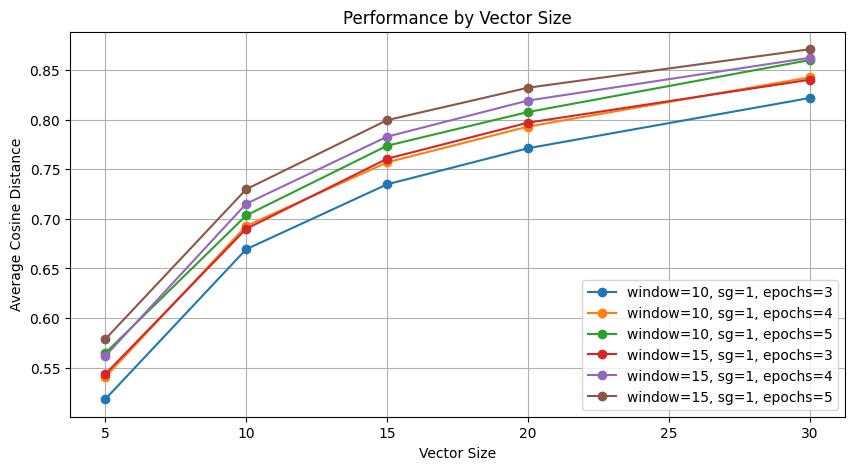

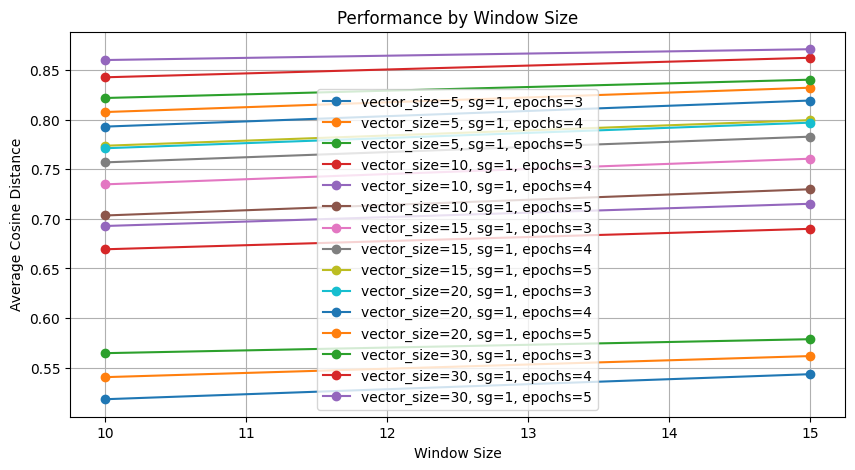

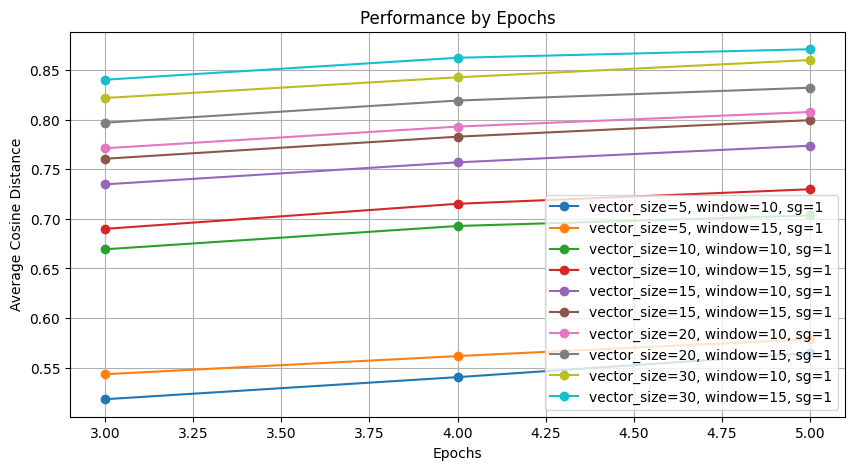

In [26]:
def plot_results(results):
    # Extract unique parameter values
    vector_sizes = sorted(set(param['vector_size'] for param, _ in results))
    windows = sorted(set(param['window'] for param, _ in results))
    epochs = sorted(set(param['epochs'] for param, _ in results))

    # Plot results for vector size
    plt.figure(figsize=(10, 5))
    for window in windows:
        for sg in [0, 1]:  # Assuming sg can be 0 or 1
            for epoch in epochs:
                filtered_results = [(param, distance) for param, distance in results if param['window'] == window and param['sg'] == sg and param['epochs'] == epoch]
                if filtered_results:
                    vector_sizes = [param['vector_size'] for param, _ in filtered_results]
                    distances = [distance for _, distance in filtered_results]
                    plt.plot(vector_sizes, distances, marker='o', label=f'window={window}, sg={sg}, epochs={epoch}')
    plt.xlabel('Vector Size')
    plt.ylabel('Average Cosine Distance')
    plt.title('Performance by Vector Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot results for window size
    plt.figure(figsize=(10, 5))
    for vector_size in vector_sizes:
        for sg in [0, 1]:  # Assuming sg can be 0 or 1
            for epoch in epochs:
                filtered_results = [(param, distance) for param, distance in results if param['vector_size'] == vector_size and param['sg'] == sg and param['epochs'] == epoch]
                if filtered_results:
                    windows = [param['window'] for param, _ in filtered_results]
                    distances = [distance for _, distance in filtered_results]
                    plt.plot(windows, distances, marker='o', label=f'vector_size={vector_size}, sg={sg}, epochs={epoch}')
    plt.xlabel('Window Size')
    plt.ylabel('Average Cosine Distance')
    plt.title('Performance by Window Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot results for epochs
    plt.figure(figsize=(10, 5))
    for vector_size in vector_sizes:
        for window in windows:
            for sg in [0, 1]:  # Assuming sg can be 0 or 1
                filtered_results = [(param, distance) for param, distance in results if param['vector_size'] == vector_size and param['window'] == window and param['sg'] == sg]
                if filtered_results:
                    epochs = [param['epochs'] for param, _ in filtered_results]
                    distances = [distance for _, distance in filtered_results]
                    plt.plot(epochs, distances, marker='o', label=f'vector_size={vector_size}, window={window}, sg={sg}')
    plt.xlabel('Epochs')
    plt.ylabel('Average Cosine Distance')
    plt.title('Performance by Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_results(results)
